In [1]:
import pandas as pd
# Đọc tệp CSV
df = pd.read_csv('fer2013.csv')
print("Dataframe loaded successfully.")


Dataframe loaded successfully.


In [2]:
# Kiểm tra thông tin chung về DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB
None


In [3]:
# Hiển thị 5 dòng đầu tiên của DataFrame
print(df.head())

# Hiển thị 5 dòng cuối cùng của DataFrame
print(df.tail())

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
       emotion                                             pixels        Usage
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest


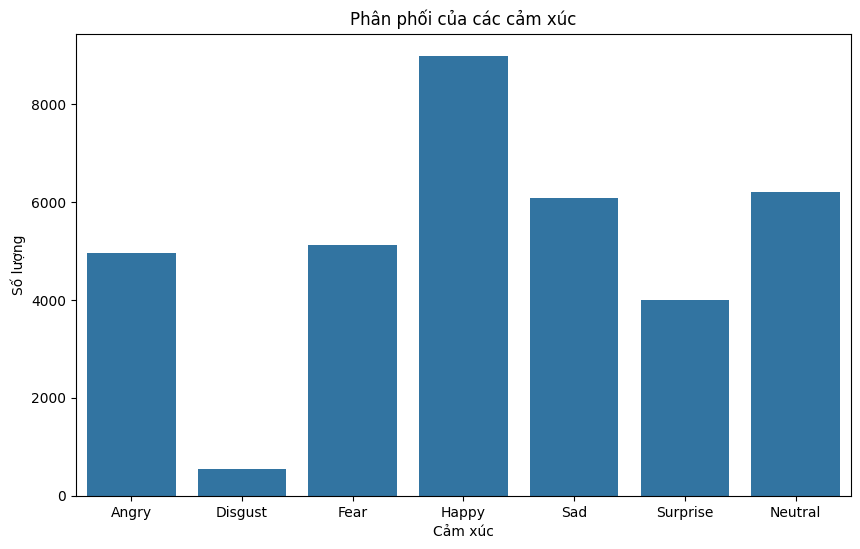

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Định nghĩa tên cho các loại cảm xúc
emotion_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Biểu đồ cột cho phân phối của cột 'emotion' với tên của các cảm xúc
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='emotion')
plt.title('Phân phối của các cảm xúc')
plt.xlabel('Cảm xúc')
plt.ylabel('Số lượng')
plt.xticks(ticks=range(7), labels=emotion_names)  # Đặt tên cho các nhãn trên trục x
plt.show()

In [5]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def load_data(data_path):
    data = pd.read_csv(data_path)
    images = []
    labels = []
    for index, row in data.iterrows():
        image = np.fromstring(row['pixels'], dtype=int, sep=' ').reshape((48, 48))
        images.append(image)
        labels.append(row['emotion'])
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

data_path = 'C:/Users/Dell Latitude 5450/Documents/Jupyter Notebook/deep_learning/fer2013.csv'

images, labels = load_data(data_path)
images = images.reshape(-1, 48, 48, 1).astype('float32') / 255.0
labels = to_categorical(labels, num_classes=7)  # FER-2013 có 7 loại cảm xúc

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)



In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# Xây dựng mô hình
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(7, activation='softmax')
])

# Biên dịch mô hình
optimizer = Adam(learning_rate=0.001)  # Giảm learning rate để mô hình hội tụ chậm và ổn định hơn
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Sử dụng ReduceLROnPlateau callback để giảm learning rate nếu mất kiên nhẫn trong quá trình huấn luyện
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)

# Huấn luyện mô hình
history = model.fit(x_train, y_train, epochs=1, batch_size=64, validation_split=0.2)

# Đánh giá mô hình
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

# Lưu mô hình
model.save('improved_emotion_recognition_model.h5')

225/225 [==============================] - 20s 89ms/step - loss: 1.8159 - accuracy: 0.2634
Test accuracy: 0.26344385743141174


In [14]:
import numpy as np
import cv2
import tensorflow as tf

# Tải mô hình đã lưu
model = tf.keras.models.load_model('improved_emotion_recognition_model.h5')

def predict_emotion(image_path, model):
    # Đọc ảnh
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Không thể đọc ảnh từ đường dẫn cung cấp.")

    # Thay đổi kích thước ảnh về 48x48
    image = cv2.resize(image, (48, 48))

    # Chuẩn bị ảnh cho dự đoán
    image = image.reshape(1, 48, 48, 1).astype('float32') / 255.0

    # Dự đoán cảm xúc
    prediction = model.predict(image)

    # Gán nhãn cho các cảm xúc
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    # Trả về cảm xúc dự đoán
    return emotion_labels[np.argmax(prediction)]

# Đường dẫn tới ảnh cần dự đoán
image_path = 'C:/Users/Dell Latitude 5450/Documents/Jupyter Notebook/face_reco/a.JPG'  # Thay thế bằng đường dẫn thực tế tới ảnh cần dự đoán

# Dự đoán cảm xúc
predicted_emotion = predict_emotion(image_path, model)
print(f'Predicted emotion: {predicted_emotion}')


Predicted emotion: Happy


In [15]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import cv2
import numpy as np
import tensorflow as tf

# Load the pre-trained model
model = tf.keras.models.load_model('improved_emotion_recognition_model.h5')

# Function to predict emotion from an image path
def predict_emotion(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (48, 48))
    image = image.reshape(1, 48, 48, 1).astype('float32') / 255.0
    prediction = model.predict(image)
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    return emotion_labels[np.argmax(prediction)]

# Function to upload image
def upload_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        img = Image.open(file_path)
        img = img.resize((200, 200))
        img = ImageTk.PhotoImage(img)
        panel.configure(image=img)
        panel.image = img
        emotion = predict_emotion(file_path)
        label.config(text=f'Emotion: {emotion}')

# Function to capture image from webcam
def capture_image():
    cap = cv2.VideoCapture(0)
    ret, frame = cap.read()
    if ret:
        cv2.imwrite('captured_image.jpg', frame)
        cap.release()
        cv2.destroyAllWindows()
        img = Image.open('captured_image.jpg')
        img = img.resize((200, 200))
        img = ImageTk.PhotoImage(img)
        panel.configure(image=img)
        panel.image = img
        emotion = predict_emotion('captured_image.jpg')
        label.config(text=f'Emotion: {emotion}')

# Set up the main window
root = tk.Tk()
root.title("Emotion Recognition")
root.geometry("400x400")

# Create buttons and labels
upload_btn = tk.Button(root, text="Upload Image", command=upload_image)
upload_btn.pack(pady=10)
capture_btn = tk.Button(root, text="Capture Image", command=capture_image)
capture_btn.pack(pady=10)
panel = tk.Label(root)
panel.pack(pady=10)
label = tk.Label(root, text="Emotion: ")
label.pack(pady=10)

# Run the application
root.mainloop()


In [24]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import cv2
import numpy as np
import tensorflow as tf

# Tải mô hình đã lưu
model = tf.keras.models.load_model('improved_emotion_recognition_model.h5')

def predict_emotion(image_path, model):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Không thể đọc ảnh từ đường dẫn cung cấp.")
    image = cv2.resize(image, (48, 48))
    image = image.reshape(1, 48, 48, 1).astype('float32') / 255.0
    prediction = model.predict(image)
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    return emotion_labels[np.argmax(prediction)]

def upload_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        try:
            img = Image.open(file_path)
            img = img.resize((200, 200))
            img = ImageTk.PhotoImage(img)
            panel.configure(image=img)
            panel.image = img
            emotion = predict_emotion(file_path, model)
            label.config(text=f'Cảm xúc: {emotion}')
        except Exception as e:
            label.config(text=f'Lỗi: {str(e)}')

def capture_image():
    cap = cv2.VideoCapture(0)
    ret, frame = cap.read()
    if ret:
        cv2.imwrite('captured_image.jpg', frame)
        cap.release()
        cv2.destroyAllWindows()
        try:
            img = Image.open('captured_image.jpg')
            img = img.resize((200, 200))
            img = ImageTk.PhotoImage(img)
            panel.configure(image=img)
            panel.image = img
            emotion = predict_emotion('captured_image.jpg', model)
            label.config(text=f'Cảm xúc: {emotion}')
        except Exception as e:
            label.config(text=f'Lỗi: {str(e)}')
    else:
        label.config(text="Không thể chụp ảnh từ webcam")

root = tk.Tk()
root.title("Nhận diện cảm xúc")
root.geometry("400x400")

upload_btn = tk.Button(root, text="Tải ảnh lên", command=upload_image)
upload_btn.pack(pady=10)
capture_btn = tk.Button(root, text="Chụp ảnh", command=capture_image)
capture_btn.pack(pady=10)
panel = tk.Label(root)
panel.pack(pady=10)
label = tk.Label(root, text="Cảm xúc: ")
label.pack(pady=10)

root.mainloop()

In [57]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import cv2
import numpy as np
import tensorflow as tf

# Tải mô hình đã lưu
model = tf.keras.models.load_model('improved_emotion_recognition_model.h5')

def predict_emotion(image_path, model):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Không thể đọc ảnh từ đường dẫn cung cấp.")
    image = cv2.resize(image, (48, 48))
    image = image.reshape(1, 48, 48, 1).astype('float32') / 255.0
    prediction = model.predict(image)
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    return emotion_labels[np.argmax(prediction)]

def upload_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        try:
            img = Image.open(file_path)
            img = img.resize((200, 200))
            img = ImageTk.PhotoImage(img)
            panel.configure(image=img)
            panel.image = img
            emotion = predict_emotion(file_path, model)
            label.config(text=f'Cảm xúc: {emotion}')
        except Exception as e:
            label.config(text=f'Lỗi: {str(e)}')

def capture_image():
    cap = cv2.VideoCapture(0)
    ret, frame = cap.read()
    if ret:
        cv2.imwrite('captured_image.jpg', frame)
        cap.release()
        cv2.destroyAllWindows()
        try:
            img = Image.open('captured_image.jpg')
            img = img.resize((200, 200))
            img = ImageTk.PhotoImage(img)
            panel.configure(image=img)
            panel.image = img
            emotion = predict_emotion('captured_image.jpg', model)
            label.config(text=f'Cảm xúc: {emotion}')
        except Exception as e:
            label.config(text=f'Lỗi: {str(e)}')
    else:
        label.config(text="Không thể chụp ảnh từ webcam")

root = tk.Tk()
root.title("Nhận diện cảm xúc")
root.geometry("600x400")
root.resizable(False, False)  

upload_btn = tk.Button(root, text="Tải ảnh lên", command=upload_image, bg='light green', fg='black', activebackground='blue', activeforeground='white')
upload_btn.pack(pady=10)
capture_btn = tk.Button(root, text="Chụp ảnh", command=capture_image, bg='light blue', fg='dark blue', activebackground='blue', activeforeground='white')
capture_btn.pack(pady=10)
panel = tk.Label(root)
panel.pack(pady=10)
label = tk.Label(root, text="Cảm xúc: ")
label.pack(pady=10)

root.mainloop()

In [85]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import cv2
import numpy as np
import tensorflow as tf

# Tải mô hình đã lưu
model = tf.keras.models.load_model('improved_emotion_recognition_model.h5')

def predict_emotion(image, model):
    if image is None:
        raise ValueError("Không thể đọc ảnh từ đường dẫn cung cấp.")
    image = cv2.resize(image, (48, 48))
    image = image.reshape(1, 48, 48, 1).astype('float32') / 255.0
    prediction = model.predict(image)
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    return emotion_labels[np.argmax(prediction)]

def upload_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        try:
            img = Image.open(file_path)
            img = img.resize((200, 200))
            img = ImageTk.PhotoImage(img)
            panel.configure(image=img)
            panel.image = img
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            emotion = predict_emotion(image, model)
            label.config(text=f'Cảm xúc: {emotion}')
        except Exception as e:
            label.config(text=f'Lỗi: {str(e)}')

def capture_image():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        label.config(text="Không thể mở webcam")
        return
    ret, frame = cap.read()
    if ret:
        cv2.imwrite('captured_image.jpg', frame)
        img = Image.open('captured_image.jpg')
        img = img.resize((200, 200))
        img = ImageTk.PhotoImage(img)
        panel.configure(image=img)
        panel.image = img
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        emotion = predict_emotion(gray, model)
        label.config(text=f'Cảm xúc: {emotion}')
    cap.release()

def capture_and_predict_emotion():
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        label.config(text="Không thể mở webcam")
        return
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        for (x, y, w, h) in faces:
            face_gray = gray[y:y+h, x:x+w]
            emotion = predict_emotion(face_gray, model)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.imshow('Nhận diện cảm xúc', frame)
        if cv2.waitKey(1) == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

root = tk.Tk()
root.title("Nhận diện cảm xúc")
root.geometry("600x400")
root.resizable(False, False)  

upload_btn = tk.Button(root, text="Tải ảnh lên", command=upload_image, bg='light green', fg='black', activebackground='blue', activeforeground='white', width=20)
upload_btn.pack(pady=10)
capture_btn = tk.Button(root, text="Chụp ảnh", command=capture_image, bg='light yellow', fg='black', activebackground='blue', activeforeground='white', width=20)
capture_btn.pack(pady=10)
emotion_btn = tk.Button(root, text="Camera", command=capture_and_predict_emotion, bg='light blue', fg='dark blue', activebackground='blue', activeforeground='white', width=20)
emotion_btn.pack(pady=10)
panel = tk.Label(root)
panel.pack(pady=10)
label = tk.Label(root, text="Cảm xúc: ")
label.pack(pady=10)

root.mainloop()

TypeError: weight_decay is not a valid argument, kwargs should be empty  for `optimizer_experimental.Optimizer`.

In [ ]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import cv2
import numpy as np
import tensorflow as tf

# Tải mô hình mà không bao gồm thông tin về trình tối ưu hóa
model = tf.keras.models.load_model('improved_emotion_recognition_model.h5', compile=False)


def detect_and_crop_face(image_path):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Không thể đọc ảnh từ đường dẫn cung cấp.")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        raise ValueError("Không tìm thấy khuôn mặt nào trong ảnh.")
    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        break
    return face, (x, y, w, h), image

def predict_emotion(image_path, model):
    face, (x, y, w, h), original_image = detect_and_crop_face(image_path)
    face_resized = cv2.resize(face, (48, 48))
    face_normalized = face_resized.reshape(1, 48, 48, 1).astype('float32') / 255.0
    prediction = model.predict(face_normalized)
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    predicted_emotion = emotion_labels[np.argmax(prediction)]
    cv2.putText(original_image, predicted_emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.rectangle(original_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    #plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    #plt.title(f'Predicted Emotion: {predicted_emotion}')
    #plt.axis('off')
    #plt.show()
    return predicted_emotion

def upload_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        try:
            img = Image.open(file_path)
            img = img.resize((200, 200))
            img = ImageTk.PhotoImage(img)
            panel.configure(image=img)
            panel.image = img
            emotion = predict_emotion(file_path, model)
            label.config(text=f'Cảm xúc: {emotion}')
        except Exception as e:
            label.config(text=f'Lỗi: {str(e)}')

def capture_image():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        label.config(text="Không thể mở webcam")
        return
    ret, frame = cap.read()
    if ret:
        cv2.imwrite('captured_image.jpg', frame)
        img = Image.open('captured_image.jpg')
        img = img.resize((200, 200))
        img = ImageTk.PhotoImage(img)
        panel.configure(image=img)
        panel.image = img
        emotion = predict_emotion('captured_image.jpg', model)
        label.config(text=f'Cảm xúc: {emotion}')
    cap.release()

def capture_and_predict_emotion():
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        label.config(text="Không thể mở webcam")
        return
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        for (x, y, w, h) in faces:
            face_gray = gray[y:y+h, x:x+w]
            face_resized = cv2.resize(face_gray, (48, 48))
            face_normalized = face_resized.reshape(1, 48, 48, 1).astype('float32') / 255.0
            prediction = model.predict(face_normalized)
            emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
            emotion = emotion_labels[np.argmax(prediction)]
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.imshow('Nhận diện cảm xúc', frame)
        if cv2.waitKey(1) == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

root = tk.Tk()
root.title("Nhận diện cảm xúc")
root.geometry("600x400")
root.resizable(False, False)

upload_btn = tk.Button(root, text="Tải ảnh lên", command=upload_image, bg='light green', fg='black', activebackground='blue', activeforeground='white', width=20)
upload_btn.pack(pady=10)
capture_btn = tk.Button(root, text="Chụp ảnh", command=capture_image, bg='light yellow', fg='black', activebackground='blue', activeforeground='white', width=20)
capture_btn.pack(pady=10)
emotion_btn = tk.Button(root, text="Camera", command=capture_and_predict_emotion, bg='light blue', fg='dark blue', activebackground='blue', activeforeground='white', width=20)
emotion_btn.pack(pady=10)
panel = tk.Label(root)
panel.pack(pady=10)
label = tk.Label(root, text="Cảm xúc: ")
label.pack(pady=10)

root.mainloop()


: 

In [ ]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import cv2
import numpy as np
import tensorflow as tf

# Tải mô hình mà không bao gồm thông tin về trình tối ưu hóa
model = tf.keras.models.load_model('improved_emotion_recognition_model.h5', compile=False)


def detect_and_crop_face(image_path):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Không thể đọc ảnh từ đường dẫn cung cấp.")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        raise ValueError("Không tìm thấy khuôn mặt nào trong ảnh.")
    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        break
    return face, (x, y, w, h), image

def predict_emotion(image_path, model):
    face, (x, y, w, h), original_image = detect_and_crop_face(image_path)
    face_resized = cv2.resize(face, (48, 48))
    face_normalized = face_resized.reshape(1, 48, 48, 1).astype('float32') / 255.0
    prediction = model.predict(face_normalized)
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    predicted_emotion = emotion_labels[np.argmax(prediction)]
    cv2.putText(original_image, predicted_emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.rectangle(original_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    #plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    #plt.title(f'Predicted Emotion: {predicted_emotion}')
    #plt.axis('off')
    #plt.show()
    return predicted_emotion

def upload_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        try:
            img = Image.open(file_path)
            img = img.resize((200, 200))
            img = ImageTk.PhotoImage(img)
            panel.configure(image=img)
            panel.image = img
            emotion = predict_emotion(file_path, model)
            label.config(text=f'Cảm xúc: {emotion}')
        except Exception as e:
            label.config(text=f'Lỗi: {str(e)}')

def display_image():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        label.config(text="Không thể mở webcam")
        return
    ret, frame = cap.read()
    if ret:
        cv2.imshow('Webcam', frame)
        cv2.waitKey(0)
        cap.release()

def capture_image():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        label.config(text="Không thể mở webcam")
        return
    ret, frame = cap.read()
    if ret:
        cv2.imwrite('captured_image.jpg', frame)
        img = Image.open('captured_image.jpg')
        img = img.resize((200, 200))
        img = ImageTk.PhotoImage(img)
        panel.configure(image=img)
        panel.image = img
        emotion = predict_emotion('captured_image.jpg', model)
        label.config(text=f'Cảm xúc: {emotion}')
    cap.release()

# Replace the command of capture_btn with display_image
capture_btn = tk.Button(root, text="Chụp ảnh", command=display_image, bg='light yellow', fg='black', activebackground='blue', activeforeground='white', width=20) activeforeground='white', width=20)

def capture_and_predict_emotion():
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        label.config(text="Không thể mở webcam")
        return
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        for (x, y, w, h) in faces:
            face_gray = gray[y:y+h, x:x+w]
            face_resized = cv2.resize(face_gray, (48, 48))
            face_normalized = face_resized.reshape(1, 48, 48, 1).astype('float32') / 255.0
            prediction = model.predict(face_normalized)
            emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
            emotion = emotion_labels[np.argmax(prediction)]
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.imshow('Nhận diện cảm xúc', frame)
        if cv2.waitKey(1) == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

root = tk.Tk()
root.title("Nhận diện cảm xúc")
root.geometry("600x400")
root.resizable(False, False)

upload_btn = tk.Button(root, text="Tải ảnh lên", command=upload_image, bg='light green', fg='black', activebackground='blue', activeforeground='white', width=20)
upload_btn.pack(pady=10)
capture_btn = tk.Button(root, text="Chụp ảnh", command=capture_image, bg='light yellow', fg='black', activebackground='blue', activeforeground='white', width=20)
capture_btn.pack(pady=10)
emotion_btn = tk.Button(root, text="Camera", command=capture_and_predict_emotion, bg='light blue', fg='dark blue', activebackground='blue', activeforeground='white', width=20)
emotion_btn.pack(pady=10)
panel = tk.Label(root)
panel.pack(pady=10)
label = tk.Label(root, text="Cảm xúc: ")
label.pack(pady=10)

root.mainloop()


TclError: can't invoke "button" command: application has been destroyed

In [1]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import cv2
import numpy as np
import tensorflow as tf

# Tải mô hình mà không bao gồm thông tin về trình tối ưu hóa
model = tf.keras.models.load_model('improved_emotion_recognition_model.h5', compile=False)


def detect_and_crop_face(image_path):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Không thể đọc ảnh từ đường dẫn cung cấp.")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        raise ValueError("Không tìm thấy khuôn mặt nào trong ảnh.")
    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        break
    return face, (x, y, w, h), image

def predict_emotion(image_path, model):
    face, (x, y, w, h), original_image = detect_and_crop_face(image_path)
    face_resized = cv2.resize(face, (48, 48))
    face_normalized = face_resized.reshape(1, 48, 48, 1).astype('float32') / 255.0
    prediction = model.predict(face_normalized)
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    predicted_emotion = emotion_labels[np.argmax(prediction)]
    cv2.putText(original_image, predicted_emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.rectangle(original_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    #plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    #plt.title(f'Predicted Emotion: {predicted_emotion}')
    #plt.axis('off')
    #plt.show()
    return predicted_emotion

def upload_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        try:
            img = Image.open(file_path)
            img = img.resize((200, 200))
            img = ImageTk.PhotoImage(img)
            panel.configure(image=img)
            panel.image = img
            emotion = predict_emotion(file_path, model)
            label.config(text=f'Cảm xúc: {emotion}')
        except Exception as e:
            label.config(text=f'Lỗi: {str(e)}')

def capture_image():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        label.config(text="Không thể mở webcam")
        return
    ret, frame = cap.read()
    if ret:
        cv2.imwrite('captured_image.jpg', frame)
        img = Image.open('captured_image.jpg')
        img = img.resize((200, 200))
        img = ImageTk.PhotoImage(img)
        panel.configure(image=img)
        panel.image = img
        emotion = predict_emotion('captured_image.jpg', model)
        label.config(text=f'Cảm xúc: {emotion}')
    cap.release()

def capture_and_predict_emotion():
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        label.config(text="Không thể mở webcam")
        return
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        for (x, y, w, h) in faces:
            face_gray = gray[y:y+h, x:x+w]
            face_resized = cv2.resize(face_gray, (48, 48))
            face_normalized = face_resized.reshape(1, 48, 48, 1).astype('float32') / 255.0
            prediction = model.predict(face_normalized)
            emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
            emotion = emotion_labels[np.argmax(prediction)]
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.imshow('Nhận diện cảm xúc', frame)
        if cv2.waitKey(1) == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

root = tk.Tk()
root.title("Nhận diện cảm xúc")
root.geometry("600x400")
root.resizable(False, False)

upload_btn = tk.Button(root, text="Tải ảnh lên", command=upload_image, bg='light green', fg='black', activebackground='blue', activeforeground='white', width=20)
upload_btn.pack(pady=10)
capture_btn = tk.Button(root, text="Chụp ảnh", command=capture_image, bg='light yellow', fg='black', activebackground='blue', activeforeground='white', width=20)
capture_btn.pack(pady=10)
emotion_btn = tk.Button(root, text="Camera", command=capture_and_predict_emotion, bg='light blue', fg='dark blue', activebackground='blue', activeforeground='white', width=20)
emotion_btn.pack(pady=10)
panel = tk.Label(root)
panel.pack(pady=10)
label = tk.Label(root, text="Cảm xúc: ")
label.pack(pady=10)

root.mainloop()


In [4]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import cv2
import numpy as np
import tensorflow as tf

# Tải mô hình mà không bao gồm thông tin về trình tối ưu hóa
model = tf.keras.models.load_model('improved_emotion_recognition_model.h5', compile=False)


def detect_and_crop_face(image_path):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Không thể đọc ảnh từ đường dẫn cung cấp.")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        raise ValueError("Không tìm thấy khuôn mặt nào trong ảnh.")
    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        break
    return face, (x, y, w, h), image

def predict_emotion(image_path, model):
    face, (x, y, w, h), original_image = detect_and_crop_face(image_path)
    face_resized = cv2.resize(face, (48, 48))
    face_normalized = face_resized.reshape(1, 48, 48, 1).astype('float32') / 255.0
    prediction = model.predict(face_normalized)
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    predicted_emotion = emotion_labels[np.argmax(prediction)]
    cv2.putText(original_image, predicted_emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.rectangle(original_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    #plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    #plt.title(f'Predicted Emotion: {predicted_emotion}')
    #plt.axis('off')
    #plt.show()
    return predicted_emotion

def upload_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        try:
            img = Image.open(file_path)
            img = img.resize((200, 200))
            img = ImageTk.PhotoImage(img)
            panel.configure(image=img)
            panel.image = img
            emotion = predict_emotion(file_path, model)
            label.config(text=f'Cảm xúc: {emotion}')
        except Exception as e:
            label.config(text=f'Lỗi: {str(e)}')

image_counter = 0

def capture_image():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        label.config(text="Không thể mở webcam")
        return
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imshow('Camera', frame)
        key = cv2.waitKey(1)
        if key == ord('c'):  # 'c' key for capturing the image
            cv2.imwrite('captured_image.jpg', frame)
            img = Image.open('captured_image.jpg')
            img = img.resize((200, 200))
            img = ImageTk.PhotoImage(img)
            panel.configure(image=img)
            panel.image = img
            emotion = predict_emotion('captured_image.jpg', model)
            label.config(text=f'Cảm xúc: {emotion}')
            break
        elif key == ord('q'):  # 'q' key for quitting the camera feed
            break
    cap.release()
    cv2.destroyAllWindows()

def capture_and_predict_emotion():
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        label.config(text="Không thể mở webcam")
        return
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        for (x, y, w, h) in faces:
            face_gray = gray[y:y+h, x:x+w]
            face_resized = cv2.resize(face_gray, (48, 48))
            face_normalized = face_resized.reshape(1, 48, 48, 1).astype('float32') / 255.0
            prediction = model.predict(face_normalized)
            emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
            emotion = emotion_labels[np.argmax(prediction)]
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.imshow('Nhận diện cảm xúc', frame)
        if cv2.waitKey(1) == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

root = tk.Tk()
root.title("Nhận diện cảm xúc")
root.geometry("600x400")
root.resizable(False, False)

upload_btn = tk.Button(root, text="Tải ảnh lên", command=upload_image, bg='light green', fg='black', activebackground='blue', activeforeground='white', width=20)
upload_btn.pack(pady=10)
capture_btn = tk.Button(root, text="Chụp ảnh", command=capture_image, bg='light yellow', fg='black', activebackground='blue', activeforeground='white', width=20)
capture_btn.pack(pady=10)
emotion_btn = tk.Button(root, text="Camera", command=capture_and_predict_emotion, bg='light blue', fg='dark blue', activebackground='blue', activeforeground='white', width=20)
emotion_btn.pack(pady=10)
panel = tk.Label(root)
panel.pack(pady=10)
label = tk.Label(root, text="Cảm xúc: ")
label.pack(pady=10)

root.mainloop()


In [16]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import cv2
import numpy as np
import tensorflow as tf

# Tải mô hình mà không bao gồm thông tin về trình tối ưu hóa
model = tf.keras.models.load_model('improved_emotion_recognition_model.h5', compile=False)


def detect_and_crop_face(image_path):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Không thể đọc ảnh từ đường dẫn cung cấp.")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        raise ValueError("Không tìm thấy khuôn mặt nào trong ảnh.")
    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        break
    return face, (x, y, w, h), image

def predict_emotion(image_path, model):
    face, (x, y, w, h), original_image = detect_and_crop_face(image_path)
    face_resized = cv2.resize(face, (48, 48))
    face_normalized = face_resized.reshape(1, 48, 48, 1).astype('float32') / 255.0
    prediction = model.predict(face_normalized)
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    predicted_emotion = emotion_labels[np.argmax(prediction)]
    cv2.putText(original_image, predicted_emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.rectangle(original_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    #plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    #plt.title(f'Predicted Emotion: {predicted_emotion}')
    #plt.axis('off')
    #plt.show()
    return predicted_emotion

def upload_image():
    file_path = filedialog.askopenfilename()
    if file_path:
        try:
            img = Image.open(file_path)
            img = img.resize((200, 200))
            img = ImageTk.PhotoImage(img)
            panel.configure(image=img)
            panel.image = img
            emotion = predict_emotion(file_path, model)
            label.config(text=f'Cảm xúc: {emotion}')
        except Exception as e:
            label.config(text=f'Lỗi: {str(e)}')

image_counter = 0

def capture_image():
    global image_counter  # Sử dụng biến toàn cục
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        label.config(text="Không thể mở webcam")
        return
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imshow('Camera', frame)
        key = cv2.waitKey(1)
        if key == ord('c'):  # Nhấn phím 'c' để chụp ảnh
            image_name = f'{image_counter}.jpg'  # Đặt tên cho ảnh
            cv2.imwrite(image_name, frame)
            img = Image.open(image_name)
            img = img.resize((200, 200))
            img = ImageTk.PhotoImage(img)
            panel.configure(image=img)
            panel.image = img
            emotion = predict_emotion(image_name, model)
            label.config(text=f'Cảm xúc: {emotion}')
            image_counter += 1  # Tăng biến đếm sau khi chụp ảnh
            break
        elif key == ord('q'):  # Nhấn phím 'q' để thoát camera
            break
    cap.release()
    cv2.destroyAllWindows()

def capture_and_predict_emotion():
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        label.config(text="Không thể mở webcam")
        return
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        for (x, y, w, h) in faces:
            face_gray = gray[y:y+h, x:x+w]
            face_resized = cv2.resize(face_gray, (48, 48))
            face_normalized = face_resized.reshape(1, 48, 48, 1).astype('float32') / 255.0
            prediction = model.predict(face_normalized)
            emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
            emotion = emotion_labels[np.argmax(prediction)]
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.imshow('Nhận diện cảm xúc', frame)
        if cv2.waitKey(1) == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

root = tk.Tk()
root.title("Nhận diện cảm xúc")
root.geometry("600x400")
root.resizable(False, False)

upload_btn = tk.Button(root, text="Tải ảnh lên", command=upload_image, bg='light green', fg='black', activebackground='blue', activeforeground='white', width=20)
upload_btn.pack(pady=10)
capture_btn = tk.Button(root, text="Chụp ảnh", command=capture_image, bg='light yellow', fg='black', activebackground='blue', activeforeground='white', width=20)
capture_btn.pack(pady=10)
emotion_btn = tk.Button(root, text="Camera", command=capture_and_predict_emotion, bg='light blue', fg='dark blue', activebackground='blue', activeforeground='white', width=20)
emotion_btn.pack(pady=10)
panel = tk.Label(root)
panel.pack(pady=10)
label = tk.Label(root, text="Cảm xúc: ")
label.pack(pady=10)

root.mainloop()
